In [63]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [64]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [65]:
def load_video(path:str) -> List[float]: 
    # Записываем фреймы видео после грейскейла
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) # Изолирование положения губ 
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [66]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
# Используем tf.keras.layers.StringLookup чтобы превращать char в num и наоборот. 
# Например, char_to_num(['i', 'g', 'o', 'r']) вернет <tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 9,  7, 15, 18])>
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") # oov_token - значение для неизветсного токена
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
) # invert=True - num to char 


In [67]:
# Загружаем слова и токенизируем
def load_words(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        everything = f.readlines() # Считываем строки 
    tokens = []
    for line in everything:
        line = line.split() # Разделяем временные значения и сами строки
        if line[2] != 'sil': # Убираем тишину
            tokens = [*tokens,' ',line[2]] # Добавляем в tokens через пробел
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [68]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = f'Lip reader/data/s1/{file_name}.mpg'
    words_path = f'Lip reader/data/alignments/s1/{file_name}.align'
    frames = load_video(video_path) 
    words = load_words(words_path)
    
    return frames, words

In [69]:
frames, alignments = load_data(tf.convert_to_tensor('Lip reader/data/s1/bbaf2n.mpg'))

In [70]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [71]:
data = tf.data.Dataset.list_files('/Lip reader/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE) # Предзагрука
# Сплит
train = data.take(450)
test = data.skip(450)

In [72]:
sample = data.as_numpy_iterator()
val = sample.next()
frames_uint8 = tf.cast(val[0][0]*255, tf.uint8)
frames_uint8 = tf.squeeze(frames_uint8, axis=-1)
imageio.mimsave('animation.gif', frames_uint8.numpy(), fps=10)

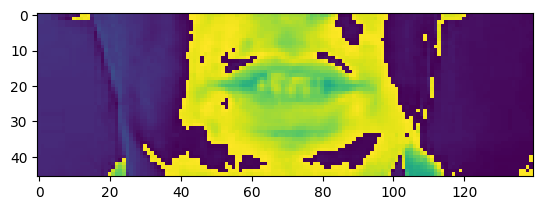

In [73]:
plt.imshow(val[0][0][30])

In [74]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [75]:
model = Sequential([
    Conv3D(128, 3, input_shape=(75,46,140,1), padding='same', activation='relu'), 
    MaxPool3D((1,2,2)), # Сжимаем 2x2
    Conv3D(256, 3, padding='same', activation='relu'),
    MaxPool3D((1,2,2)),
    Conv3D(75, 3, padding='same', activation='relu'),
    MaxPool3D((1,2,2)),
    TimeDistributed(Flatten()), # 75 для инпута в LSTM
    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)), # В обе стороны
    Dropout(.5), # Регуляризация
    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(.5),
    Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax') # 75x41  
])

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 75, 11, 35, 256)   0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                      

In [77]:
model.input_shape

(None, 75, 46, 140, 1)

In [78]:
model.output_shape

(None, 75, 41)

In [79]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [80]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [81]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [82]:
study = False
if study:
    model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [83]:
model.load_weights('/Lip reader/checkpoint')

In [84]:
test_data = test.as_numpy_iterator()
sample = test_data.next()

[mpeg1video @ 0x7f3144092280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f3144092280] Warning MVs not available


In [85]:
pred = model.predict(sample[0])

1/1 [==============================] - 1s 924ms/step


In [86]:
print('REAL TEXT')
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])
decoded = tf.keras.backend.ctc_decode(pred, input_length=[75,75], greedy=True)[0][0].numpy()
print('PREDICTED TEXT')
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])

REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by e three again'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f zero now'>]
PREDICTED TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by e three again'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lay green in zero now'>]
